In [244]:
import numpy as np
import my_geometries as mygeom 
from pointcloud import Pointcloud
import osm 
import geopandas as gpd
import matplotlib.pyplot as plt
from timer import Timer
from shapely import geometry as shapely_geom
import test_polygons
import osmnx as ox
import networkx as nx

## Generate a set of random points in 2D and find the closest pair of points. 

In [ ]:
# point parameter random points A
n_a = 100 # number of points
xmin_a = 0
xmax_a = 100
ymin_a = 0
ymax_a = 100

Generate a random poins

In [ ]:
pointcloud_a = Pointcloud.gen_random_points(
    n=n_a,
    xmin=xmin_a,
    xmax=xmax_a,
    ymin=ymin_a,
    ymax=ymax_a)

Find the closest Pair of points using Divide and Conquer Algorithm
defined in the class pointcloud.py

In [ ]:
with Timer("Execution time closest pair:"):
    dist ,(pa,pb) = pointcloud_a.closest_pair()
print(f"Distance: {dist}\nPoints:\n{pa},{pb}")

In [ ]:
# Visualization
xx_a = pointcloud_a.as_array()[:,0]
yy_a = pointcloud_a.as_array()[:,1]

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(16,9))
ax1.axis('equal')
ax2.axis('equal')
ax1.set_xlim(xmin_a,xmax_a)
ax1.set_ylim(ymin_a,ymax_a)
ax1.scatter(xx_a,yy_a, label="Points of 'pointcloud_a'")
ax1.scatter([pa.x,pb.x],[pa.y,pb.y],s=50, label="Closest pair of points")
ax1.set_title("Overview all points in 'pointcloud_a'")
ax1.legend()

center_x = (pa.x + pb.x)/2
center_y = (pa.y + pb.y)/2
# zoom is relative to the distance, in this case 5 times the distance
# of the closest pair
zoom = 5
(xmin,xmax) = (center_x - dist * zoom, center_x + dist * zoom)
(ymin,ymax) = (center_y - dist * zoom, center_y + dist * zoom)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.scatter(xx_a,yy_a)
ax2.plot([pa.x,pb.x],[pa.y,pb.y],c="black")
ax2.scatter([pa.x],[pa.y],label="Point-A",s=150)
ax2.scatter([pb.x],[pb.y], label="Point-B",s=150)
ax2.set_title("Zoomed to the closest pair of points")
ax2.legend()
plt.show()

In [ ]:
# point parameter random points B
n_b = 70 # number of points
xmin_b = 0
xmax_b = 100
ymin_b = 0
ymax_b = 100

## Given two random sets of 2D points, S1 and S2, write a function that finds the k-nearest neighbors in S2 for each point in S1.

I Wrote two function one that uses a kd-tree from scipy.spatial and one that uses brutal-force to find the nearest neighbours, we will compare the runtime

In [ ]:
# generate second point cloud
pointcloud_b = Pointcloud.gen_random_points(n_b,xmin_b,xmax_b,ymin_b,ymax_b)

# kd tree approach
with Timer("Execution Time KD-Tree-Nearest-Neighbour:"):
    points_kdtree = pointcloud_a.k_nearest_neighbour_kdtree(pointcloud_b)
# brutal force approach
with Timer("Execution Time Brutal-Force-Nearest-Neighbour:"):
    points_bf = pointcloud_a.k_nearest_neighbour_bf(pointcloud_b)
assert points_kdtree == points_bf

In [ ]:
#Visualization 
xx_b = [p.x for p in points_kdtree]
yy_b = [p.y for p in points_kdtree]

fig,ax = plt.subplots(ncols=1,figsize=(9,9))
ax.axis('equal')
ax.set_xlim(min(xmin_a,xmin_b),max(xmax_a,xmax_b))
ax.set_ylim(min(ymin_a,ymin_b),max(ymax_a,ymax_b))
ax.scatter(xx_a,yy_a, label="Points of 'pointcloud_a'")
ax.scatter(xx_b,yy_b, label="Points of 'pointcloud_b'")

for  pa,pb in zip(pointcloud_a.points,points_kdtree):
    plt.plot([pa.x,pb.x],[pa.y,pb.y],c="black",alpha=0.5)

ax.set_title("K-Nearest Neighbours Points'pointcloud_a to 'point_cloud_b'")
ax.legend()
plt.show()

# 3.a To accomplish the task, find the nearest stop/Haltestelle for all buildings in Graz city.

In [ ]:
# download the data
bus_stop_gdf = osm.get_bus_stops("Graz")
building_gdf = osm.get_buildings("Graz")

In [ ]:
# first row of bus stop geodataframe
bus_stop_gdf.head(2)

In [ ]:
# first row of building geodataframe
building_gdf.head(2)

In [ ]:
# datapreprocessing, filter out nodes from buildings and
# keep only nodes for busstops
bus_stop_gdf_new = bus_stop_gdf.reset_index()
building_gdf_new = building_gdf.reset_index()
bus_stop_gdf_new = bus_stop_gdf_new[bus_stop_gdf_new["element_type"] == "node"]
building_gdf_new = building_gdf_new[building_gdf_new["element_type"] != "node"]

In [ ]:
# plot the buildings
ax = building_gdf_new.plot(figsize=(16,16),color="yellow")
ax.set_facecolor("black") # better visibility
ax.set_title("Buildings in Graz downloaded from OpenStreetMap")
plt.show()

In [ ]:
# reproject to carthesian coordinates eg. UTM Zone 32N
bus_stop_gdf_new_reprojected = bus_stop_gdf_new.copy(True)
building_gdf_new_reprojected = building_gdf_new.copy(True)
building_gdf_new_reprojected.drop_duplicates(subset=['geometry'])
bus_stop_gdf_new_reprojected.geometry = bus_stop_gdf_new_reprojected.geometry.to_crs("EPSG:32633")
building_gdf_new_reprojected.geometry = building_gdf_new_reprojected.geometry.to_crs("EPSG:32633")

print("Old Coordinates: ",bus_stop_gdf_new.geometry[0])
print("New Coordinates: ",bus_stop_gdf_new_reprojected.geometry[0])

In [ ]:
# I made my own polygon class to compute the centroids
# but it does not support multypolygons and polygons with holes
instances_mypolygon = []
instances_shapely_polygon = []
for geom in building_gdf_new_reprojected.geometry:
    try:
        poly = mygeom.Polygon.from_wkt(geom.wkt)
        instances_mypolygon.append(poly)
    except Exception as e:
        instances_shapely_polygon.append(geom)
        continue

print(f"Instances of my own Polygon Type: {len(instances_mypolygon)}",f"|| Instances of  Shapely-Polygon Type: {len(instances_shapely_polygon)}")

In [ ]:
#compute the centroids for both mypolygons and shapely-polygons
centroids_by_my_polygon = [poly.centroid() for poly in instances_mypolygon]
centroids_by_shapely = [poly.centroid for poly in instances_shapely_polygon]

In [ ]:
# visualize the centroids that I computed myself
coors_mypolygon_class = np.array([[p.x,p.y] for p in centroids_by_my_polygon ])
ax = gpd.GeoSeries([shapely_geom.Point(i) for i in coors_mypolygon_class]).plot(figsize=(7,7))
building_gdf_new_reprojected.boundary.plot(ax=ax)
center_x = coors_mypolygon_class[:,0].min() + coors_mypolygon_class[:,0].max()
center_y = coors_mypolygon_class[:,1].min() + coors_mypolygon_class[:,1].max()
center_x /= 2
center_y /= 2
ax.axis('equal')
ax.set_xlim(center_x,center_x+100)
ax.set_ylim(center_y,center_y+100)
ax.set_title("Computed Centroids")

In [ ]:
# merge both centroid-lists for the k-nearest neighbour
building_centroids = np.concatenate([coors_mypolygon_class, np.array([[p.x,p.y] for p in centroids_by_shapely])])
print("Total number of buildings: ",len(building_centroids))

In [ ]:
# create both point-clouds, eg the two sets of points
bus_station_points = np.array([[coor.x,coor.y] for coor in bus_stop_gdf_new_reprojected.geometry])
bus_station_pointcloud = Pointcloud(bus_station_points[:,0], bus_station_points[:,1])
building_pointcloud = Pointcloud(building_centroids[:,0], building_centroids[:,1])

## 3.b Perform analysis using visualizations

In [ ]:
# compute the k-nearest neighbour for stations and buildings
# two implementations one with brutal-force another one with kd-tree
with Timer("Execution time buildings and bus-stations, brutal-force:"):
    nearest_bus_stations_bf = building_pointcloud.k_nearest_neighbour_bf(bus_station_pointcloud)
    
with Timer("Execution time buildings and bus-stations, kd-tree:"):
    nearest_bus_station_knn = building_pointcloud.k_nearest_neighbour_kdtree(bus_station_pointcloud)

In [ ]:
# test if both results are equal!
assert nearest_bus_station_knn == nearest_bus_stations_bf

In [ ]:
# for plotting compute center of all buildings and bus-stops
center_x = min(building_centroids[:,0].min(), bus_station_points[:,0].min() ) + max(building_centroids[:,0].max(), bus_station_points[:,0].min())
center_y = min(building_centroids[:,1].min(), bus_station_points[:,1].min() ) + max(building_centroids[:,1].max(), bus_station_points[:,1].min())
center_x /= 2
center_y /= 2

# bounds of the plot
xmin = center_x
xmax = center_x + 500
ymin = center_y
ymax = center_y + 500

# bounds of the features, they are larger as the plot bounds
# because otherwise not all points will be connected
xmin_filter = xmin - 100
xmax_filter = xmax + 100
ymin_filter = ymin - 100
ymax_filter = ymax + 100

# filter out the shapes that are not inside the shape bounding box
# rendering takes to long if I skip this
filtered_building_centroids = gpd.GeoSeries([shapely_geom.Point(i) for i in building_centroids]).cx[xmin_filter:xmax_filter,ymin_filter:ymax_filter]
filtered_bus_stations = gpd.GeoSeries([shapely_geom.Point(i) for i in bus_station_points]).cx[xmin_filter:xmax_filter,ymin_filter:ymax_filter]
filtered_building_polygons = building_gdf_new_reprojected.cx[xmin_filter:xmax_filter,ymin_filter:ymax_filter]

filtered_connections = gpd.GeoSeries([shapely_geom.LineString([[p1.x,p1.y],[p2.x,p2.y]]) for (p1,p2) in zip(building_pointcloud, nearest_bus_station_knn)])
filtered_connections = filtered_connections.cx[xmin_filter:xmax_filter,ymin_filter:ymax_filter]

# plot the results
fig, ax = plt.subplots(figsize=(9,9))
ax.axis('equal')
filtered_building_polygons.plot(ax=ax,color="#3CA2F0",alpha=0.6,zorder=0,label="Buildings")
filtered_connections.plot(ax=ax,color="black",linewidth=1,zorder=1,alpha=0.8,label="Line to nearest bus-station")
filtered_building_centroids.plot(ax=ax,color="#FC3932",zorder=2, label="Building-Centroids")
filtered_bus_stations.plot(ax=ax,color="#2BD964",markersize=100,zorder=3, label="Bus-Station")
ax.set_facecolor("#FAFADD")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_title("K-Nearest Neighbours for the Buildings and Bus-Stations")
plt.legend()
plt.show()

## Perform overlay operation (using intersection) on sets of geometries 

### Here is my way too complicated approach to get this 10 points, I spend days on this.
I implemented the Weiler-Atherton Clipping Algorithm myself it works, but only if the result of the clipping is a single polygon. If the result is more than one polygon, my version does not work!

In [38]:
# Get some Testpolygons
graz_polygon = mygeom.Polygon.from_wkt(test_polygons.graz_polygon())
clip_polygon_1 = mygeom.Polygon.from_wkt(test_polygons.clip_polygon_1())
clip_polygon_2= mygeom.Polygon.from_wkt(test_polygons.clip_polygon_2())
clip_polygon_3 = mygeom.Polygon.from_wkt(test_polygons.clip_polygon_3())
clip_polygon_4 = mygeom.Polygon.from_wkt(test_polygons.clip_polygon_4())

In [39]:
# Execute the clipping algorithm 

with Timer("Exec. Time 'clip_polygon_1': "):
    clip_out_1 = clip_polygon_1.weiler_atherton(graz_polygon)
with Timer("Exec. Time 'clip_polygon_2': "):
    clip_out_2 = clip_polygon_2.weiler_atherton(graz_polygon)
with Timer("Exec. Time 'clip_polygon_3': "):
    clip_out_3 = clip_polygon_3.weiler_atherton(graz_polygon)
with Timer("Exec. Time 'clip_polygon_4': "):
    clip_out_4 = clip_polygon_4.weiler_atherton(graz_polygon)


Exec. Time 'clip_polygon_1':  1350.614 [μs]
Exec. Time 'clip_polygon_2':  483.794 [μs]
Exec. Time 'clip_polygon_3':  2270.5190000000002 [μs]
Exec. Time 'clip_polygon_4':  2253.812 [μs]


As can be seen in the figure below, if the clip would result in two polygons my algorithm gets confused, shapely would be the better choice here. I also did not implement any performance optimization but tried to make the code in my_geometries.py easy to understand. But for clips that result in just one polygon, it works!

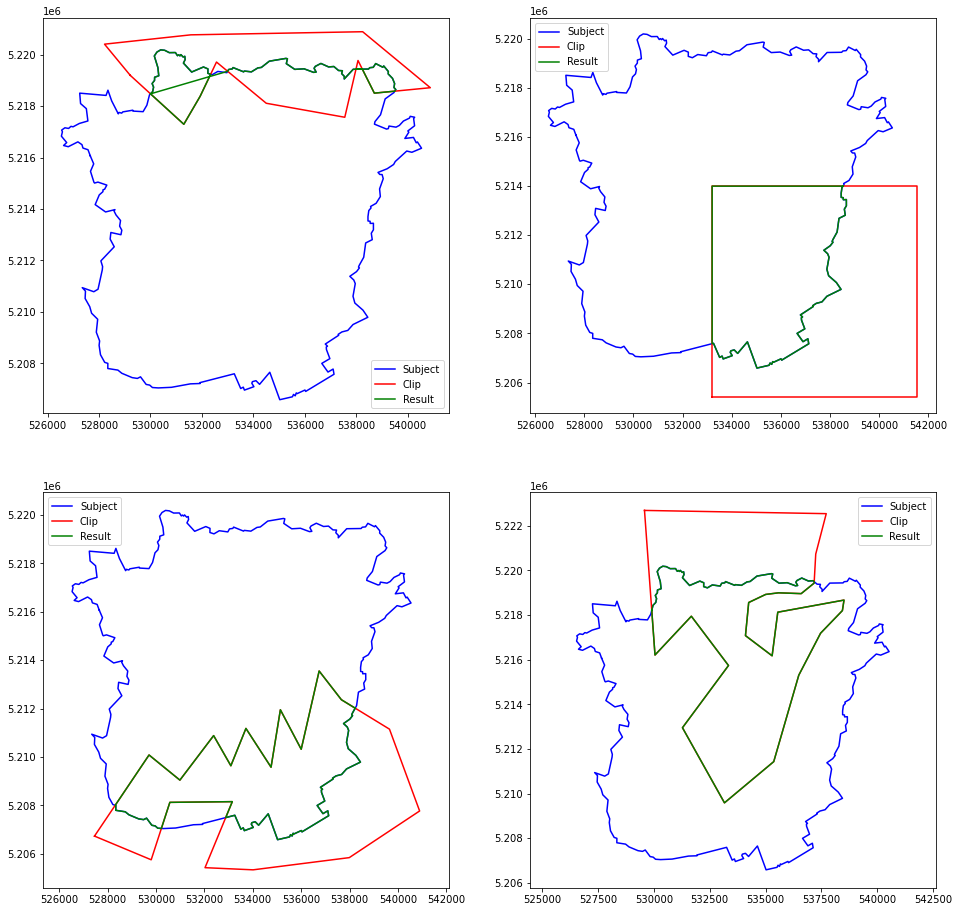

In [40]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
axs = axs.ravel()
clip_polgons = [clip_polygon_1,clip_polygon_2, clip_polygon_3, clip_polygon_4]
clipped_polygons = [clip_out_1, clip_out_2, clip_out_3, clip_out_4]
[ax.axis("equal") for ax in axs]
[ax.plot(*graz_polygon.xy, c="blue", label="Subject") for ax in axs]
[ax.plot(*clip_poly.xy, c="red", label="Clip") for ax,clip_poly in zip(axs,clip_polgons)]
[ax.plot(*out_poly.xy, c="green", label="Result") for ax,out_poly in zip(axs,clipped_polygons)]
[ax.legend() for ax in axs]
plt.show()

## Given a point and set of 2D polygons and 3D polyhedra, perform point in polygon/polyhedra (PIP) test.

Again I implemented my own version of point in polygon, seen in the Polygon-Class of "geometry.py". For Point in Polyhedra I use the scipy.spatial Delauney triangulation to check if a Point is in a Polyhedra.

The geometry I test for is very simple, but it works for more complicated polygons too, I use this method in the Weiler Atherton Clipping Method!

In [2]:
p1 = mygeom.Point([0, 0])
p2 = mygeom.Point([0, 1])
p3 = mygeom.Point([1, 1])
p4 = mygeom.Point([1, 0])
polygon = mygeom.Polygon([p1, p2, p3, p4, p1])

In [8]:
q1 = mygeom.Point((2,2))
q2 = mygeom.Point((0.5,0.5))
q3 = mygeom.Point((-2,0.5))

In [9]:
with Timer("Is Q 1 in Polygon?"):
    q1_in = polygon.point_in_polygon(q1)

with Timer("Is Q 2 in Polygon?"):
    q2_in = polygon.point_in_polygon(q2)

with Timer("Is Q 3 in Polygon?"):
    q3_in = polygon.point_in_polygon(q3)


print(f"\nq1_in:{q1_in}, q2_in: {q2_in}, q3_in: {q3_in}")

Is Q 1 in Polygon? 0.42000000000000004 [μs]
Is Q 2 in Polygon? 0.437 [μs]
Is Q 3 in Polygon? 0.62 [μs]

q1_in:False, q2_in: True, q3_in: False


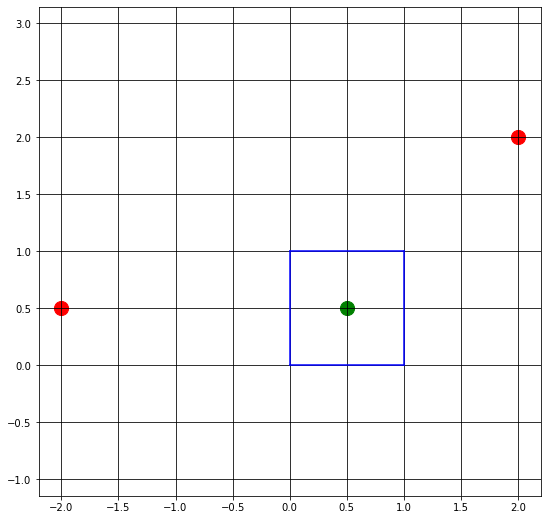

In [48]:
from importlib import reload
reload(mygeom)
fig,ax = plt.subplots(figsize=(9,9))
ax.axis("equal")

ax.grid(color="black")

for is_in, pnt in zip([q1_in,q2_in,q3_in],[q1,q2,q3]):
    if is_in:
        label = "Is in Poly"
        color = "green"
    else:
        label = "Is not in Poly"
        color = "red"
    ax.scatter(pnt.x,pnt.y, color=color,label=label,s=200)
[ax.plot(e.x, e.y,color="blue") for e in polygon.edges]

plt.show()

In [49]:
# Perform Point in Polyhedra test
p1 = mygeom.Point3D((0,0,0))
p2 = mygeom.Point3D((1,0,0))
p3 = mygeom.Point3D((0,1,0))
p4 = mygeom.Point3D((0,0,1))
polyhedra = mygeom.Polyhedra([p1,p2,p3,p4])

with Timer("PiP using Scipy.Delauney: "):
    p1_in = polyhedra.point_in_polyhedra(mygeom.Point3D([2,2,2]))

with Timer("PiP using Scipy.Delauney: "):
    p2_in = polyhedra.point_in_polyhedra(mygeom.Point3D([0.1,0.3,0.6]))

print(f"p1_in: {p1_in}, p2_in: {p2_in}")

PiP using Scipy.Delauney:  17.244 [μs]
PiP using Scipy.Delauney:  0.34900000000000003 [μs]
p1_in: False, p2_in: True


## Network analysis in Python using Networkx

### Download the routable road network of Austria from OSM using OSMnx

In [86]:
try:
    print("Loading Graph from file")
    G = ox.load_graphml("graph_austria.xml")
except FileNotFoundError:
    print("Download Graph from OSM")
    G = ox.graph_from_place("Austria", network_type="drive")
    ox.save_graphml(G,"graph_austria.xml")

Loading Graph from file


In [87]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.project_graph(G,"EPSG:3416") # Lambert 

In [88]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential', 'unclassified']",848.7,37.0,94.1
"['living_street', 'secondary']",60.7,20.0,10.9
"['living_street', 'tertiary_link']",28.6,20.0,5.2
"['living_street', 'unclassified']",326.1,25.1,54.4
"['motorway', 'motorway_link']",1379.6,96.4,48.0
...,...,...,...
tertiary_link,42.3,57.3,2.8
traffic_mirror,20.1,63.7,1.1
trunk,764.6,89.8,30.0


### Find shortest path between two given points using shortest path function of Networkx

In [89]:
orig, dest = np.random.choice(G.nodes,2,replace=False)
route = ox.shortest_path(G, orig, dest, weight="length")

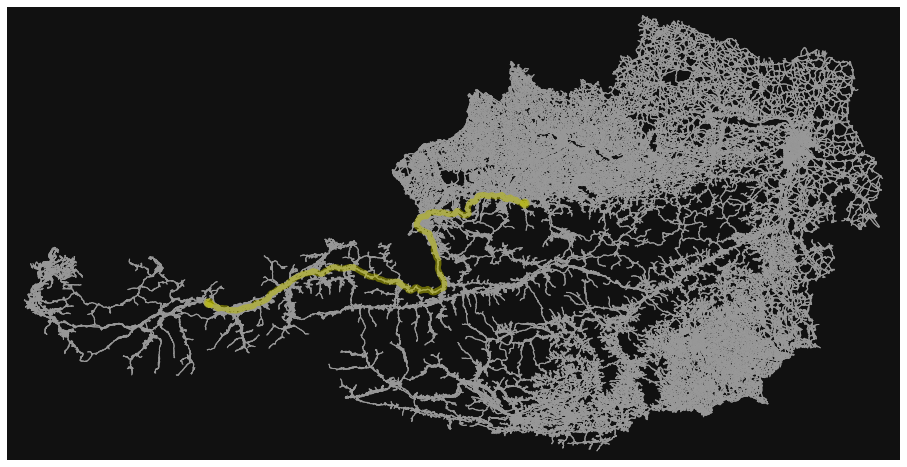

In [90]:
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0,figsize=(16,9))

Perform network statistics

In [55]:
for k,v in ox.basic_stats(G).items():
    if k =="n":
        print("Number of Edges:",v)
    elif k == "m":
        print("Numer of Nodes:",v)
    else: 
        print(f"{k}: {v}")
    

Number of Edges: 409577
Numer of Nodes: 988086
k_avg: 4.824909601857526
edge_length_total: 245314790.4520083
edge_length_avg: 248.27271153726326
streets_per_node_avg: 2.539742221853278
streets_per_node_counts: {0: 0, 1: 105785, 2: 2606, 3: 276034, 4: 24672, 5: 451, 6: 26, 7: 2, 8: 1}
streets_per_node_proportions: {0: 0.0, 1: 0.25827866310852415, 2: 0.006362661965881873, 3: 0.6739489766271055, 4: 0.06023775749126538, 5: 0.0011011360501200019, 6: 6.348012705791585e-05, 7: 4.883086696762757e-06, 8: 2.4415433483813787e-06}
intersection_count: 303792
street_length_total: 127038955.9580035
street_segment_count: 520584
street_length_avg: 244.0316182556581
circuity_avg: 1.137185510450688
self_loop_proportion: 0.0022878152229035085


### Perform street network orientation for some cities of Austria

In [347]:
places = [
    "Klagenfurt, Austria",
    "Linz, Austria",
    "Innsbruck, Austria"]


for place in places:
    
    G = ox.graph_from_place(
        place,
        network_type="drive", 
        simplify=False)
    
    phi, phi_w,h0, hw, bnw,bw = osm.orientation_analysis(G)
    data_dict[place] = bnw 
    data_dict_w[place] = bw
    print(f"{place},\n\tphi: {phi}\n\tphi_w: {phi_w}\n\th0: {h0}\n\th_w: {hw}\n\n")

osm
Klagenfurt, Austria,
	phi: 0.14012064924183576
	phi_w: 0.0947752185731775
	h0: 3.4237522741996638
	h_w: 3.4767920684360196


Linz, Austria,
	phi: 0.07889232933776702
	phi_w: 0.06130921830209024
	h0: 3.4950546144732946
	h_w: 3.5150894258919334


Innsbruck, Austria,
	phi: 0.08104869540641946
	phi_w: 0.07441954449060162
	h0: 3.492584458815604
	h_w: 3.5001690672944403


